## LRP & attention scores with Attention-LSTM
Author: Lin Lee Cheong <br>
Date: 1/13/2020

**Data:** <br>
Using the final version of 30 sequence length dataset generated by Tes<br><br>


**Steps:** <br>
1. Read in a pre-trained LSTM model
2. Define a LRP enabled model
3. Extract attention and relevance scores
4. Save to where?

In [ ]:
import sys

sys.path.append("../")

import os
import time
import torch
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from urllib.parse import urlparse
import tarfile
import pickle
import shutil

import shap
import xgboost as xgb

import sagemaker
import boto3
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.image_uris import retrieve

import deep_id_pytorch

from lstm_models import *
from att_lstm_models import *
from lstm_utils import *
from xgboost_utils import *

All parameters are defined in best_params.txt

In [5]:
nrows = 1e9
min_freq = 1
batch_size = 64

seq_len = 30

test_data_path = "../../../data/toy_dataset/data/final_event_30/test.csv"
vocab_path = "../../../data/toy_dataset/data/final_event_30/vocab"
lstm_model_path = "./model_weights/model_02.pkl"
vocab_path = 
output_save_dir = "./outputs/"

embedding_dim = 8
hidden_dim = 8
nlayers = 1
bidirectional = True
dropout = 0.3

target_colname = "label"
uid_colname = "patient_id"
target_value = "1"

rev = False

In [6]:
# Output results directory creation, as needed
for fp in [output_save_dir]:
    if not os.path.isdir(os.path.split(fp)[0]):
        print(f"New directory created: {fp}")
        os.makedirs(os.path.split(fp)[0])

print(f"Cuda available: {torch.cuda.is_available()}")
model_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

New directory created: ./outputs/
Cuda available: True


### Define and load model

In [8]:
lstm_model = AttLSTM(
    embedding_dim, hidden_dim, None, 
    model_device, nlayers=nlayers, dropout=dropout,
    linear_bias=False)
lstm_model.load_state_dict(torch.load(lstm_model_path))

TypeError: object of type 'NoneType' has no len()

In [4]:
train_dataset, vocab = build_lstm_dataset(
                                train_data_path,
                                min_freq=min_freq,
                                uid_colname="patient_id",
                                target_colname="label",
                                max_len=seq_len,
                                target_value=target_value,
                                vocab=None,
                                nrows=nrows,
                                rev=rev
                            )
valid_dataset, _ = build_lstm_dataset(
                                valid_data_path,
                                min_freq=min_freq,
                                uid_colname="patient_id",
                                target_colname="label",
                                max_len=seq_len,
                                target_value=target_value,
                                vocab=vocab,
                                nrows=nrows,
                                rev=rev
                            )

test_dataset, _ = build_lstm_dataset(
                                test_data_path,
                                min_freq=min_freq,
                                uid_colname="patient_id",
                                target_colname="label",
                                max_len=seq_len,
                                target_value=target_value,
                                vocab=vocab,
                                nrows=nrows,
                                rev=rev
                            )

Building dataset from ../../data/toy_dataset/data/train_seq300.csv..
Success!
Building dataset from ../../data/toy_dataset/data/val_seq300.csv..
Success!
Building dataset from ../../data/toy_dataset/data/test_seq300.csv..
Success!


In [5]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

In [6]:
lstm_model = AttLSTM(
    embedding_dim, hidden_dim, vocab, 
    model_device, nlayers=nlayers, dropout=dropout,
    linear_bias=False)
lstm_model = lstm_model.cuda()

## Train LSTM model

In [7]:
#loss_function = nn.CrossEntropyLoss()
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.002)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

In [8]:
best_valid_loss = float("inf")
valid_worse_loss = 0  # enable early stopping
lstm_model = lstm_model.cuda()

for epoch in range(n_epochs):

    start_time = time.time()

    train_loss, train_auc = epoch_train_lstm(
        lstm_model, train_dataloader, optimizer, loss_function, clip=True
    )

    valid_loss, valid_auc = epoch_val_lstm(
       lstm_model, valid_dataloader, loss_function)#, return_preds=False
    #)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(lstm_model.state_dict(), lstm_model_save_path)
        print("Saved Model, epoch {}".format(epoch))
        valid_worse_loss = 0

    else:
        valid_worse_loss += 1
        if valid_worse_loss == stop_num:
            print("EARLY STOP ------")
            break

    scheduler.step()
    print(
        f"Train Loss: {train_loss:.3f} | Train AUC: {train_auc:.2f} \t Val. Loss: {valid_loss:.3f} |  Val. AUC: {valid_auc:.4f}"
    )

Epoch: 01 | Epoch Time: 0m 9s
Saved Model, epoch 0
Train Loss: 0.671 | Train AUC: 0.61 	 Val. Loss: 0.417 |  Val. AUC: 0.9006
Epoch: 02 | Epoch Time: 0m 9s
Saved Model, epoch 1
Train Loss: 0.370 | Train AUC: 0.90 	 Val. Loss: 0.331 |  Val. AUC: 0.9024
Epoch: 03 | Epoch Time: 0m 9s
Saved Model, epoch 2
Train Loss: 0.343 | Train AUC: 0.90 	 Val. Loss: 0.325 |  Val. AUC: 0.9021


In [9]:
lstm_model.load_state_dict(torch.load(lstm_model_save_path))

<All keys matched successfully>

In [10]:
lstm_model

AttLSTM(
  (emb_layer): Embedding(32, 16, padding_idx=0)
  (lstm): LSTM(16, 16, batch_first=True, dropout=0.3, bidirectional=True)
  (pred_layer): Linear(in_features=64, out_features=1, bias=False)
  (dpt): Dropout(p=0.3, inplace=False)
)

## Define LRP LSTM model

In [11]:
lstm_model = lstm_model.cpu()

In [12]:
import numpy as np
from numpy import newaxis as na


def lrp_linear(hin, w, b, hout, Rout, bias_nb_units, eps, bias_factor=0.0, debug=False):
    """
    LRP for a linear layer with input dim D and output dim M.
    Args:
    - hin:            forward pass input, of shape (D,)
    - w:              connection weights, of shape (D, M)
    - b:              biases, of shape (M,)
    - hout:           forward pass output, of shape (M,) (unequal to np.dot(w.T,hin)+b if more than one incoming layer!)
    - Rout:           relevance at layer output, of shape (M,)
    - bias_nb_units:  total number of connected lower-layer units (onto which the bias/stabilizer contribution is redistributed for sanity check)
    - eps:            stabilizer (small positive number)
    - bias_factor:    set to 1.0 to check global relevance conservation, otherwise use 0.0 to ignore bias/stabilizer redistribution (recommended)
    Returns:
    - Rin:            relevance at layer input, of shape (D,)
    """
    sign_out = np.where(hout[na,:]>=0, 1., -1.) # shape (1, M)
    #numer    = (w * hin[:,na]) + ( (bias_factor*b[na,:]*1.) * 1./bias_nb_units )
    numer    = (w * hin[:,na]) + ( bias_factor * (b[na,:]*1. + eps*sign_out*1.) / bias_nb_units ) # shape (D, M)
    # Note: here we multiply the bias_factor with both the bias b and the stabilizer eps since in fact
    # using the term (b[na,:]*1. + eps*sign_out*1.) / bias_nb_units in the numerator is only useful for sanity check
    # (in the initial paper version we were using (bias_factor*b[na,:]*1. + eps*sign_out*1.) / bias_nb_units instead)
    
    denom    = hout[na,:] + (eps*sign_out*1.)   # shape (1, M)
    
    '''
    count_lim = 2
    while count_lim > 0:
        if np.any(numer < eps) and np.any(denom < eps):
            numer = numer / (0.1 *eps)
            denom = denom / (0.1 * eps)
            
        if np.any(numer > 1e4) and np.any(denom > 1e4):
            numer = numer * eps
            denom = denom * eps
            
        count_lim -= 1
        #print("activated")
    '''  
    message  = (numer/denom) * Rout[na,:]       # shape (D, M)
    
    Rin      = message.sum(axis=1)              # shape (D,)
    
    if debug:
        print("local diff: ", Rout.sum() - Rin.sum())
    # Note: 
    # - local  layer   relevance conservation if bias_factor==1.0 and bias_nb_units==D (i.e. when only one incoming layer)
    # - global network relevance conservation if bias_factor==1.0 and bias_nb_units set accordingly to the total number of lower-layer connections 
    # -> can be used for sanity check
    
    return Rin

In [13]:
print(f"hidden_dim: {lstm_model.hidden_dim}")
print(f"emb_dim: {lstm_model.emb_dim}")
print(f"n_layers: {lstm_model.nlayers}\n")

for param, _ in lstm_model.named_parameters():
    print(f"{param} >>> {_.shape}")

hidden_dim: 16
emb_dim: 16
n_layers: 1

emb_layer.weight >>> torch.Size([32, 16])
lstm.weight_ih_l0 >>> torch.Size([64, 16])
lstm.weight_hh_l0 >>> torch.Size([64, 16])
lstm.bias_ih_l0 >>> torch.Size([64])
lstm.bias_hh_l0 >>> torch.Size([64])
lstm.weight_ih_l0_reverse >>> torch.Size([64, 16])
lstm.weight_hh_l0_reverse >>> torch.Size([64, 16])
lstm.bias_ih_l0_reverse >>> torch.Size([64])
lstm.bias_hh_l0_reverse >>> torch.Size([64])
pred_layer.weight >>> torch.Size([1, 64])


In [14]:
lstm_model.lstm

LSTM(16, 16, batch_first=True, dropout=0.3, bidirectional=True)

In [49]:
class LSTM_LRP_MultiLayer:
    def __init__(self, pymodel):
        super(LSTM_LRP_MultiLayer, self).__init__()
        
        self.init_model(pymodel)
    
    def init_model(self, pymodel):
        
        self.device = pymodel.device
        self.use_gpu = pymodel.use_gpu
        self.bidi = pymodel.bidi
        
        self.emb_dim = pymodel.emb_dim
        self.vocab = pymodel.vocab
        self.input_dim = len(self.vocab)
        self.pad_idx = pymodel.pad_idx        
        self.hidden_dim = pymodel.hidden_dim
        
        self.emb = pymodel.emb_layer.weight.detach().numpy()
        
        param_list = list(pymodel.lstm.named_parameters())
        param_dict = {}
        for param_tuple in param_list:
            param_dict[param_tuple[0]] = param_tuple[-1].detach().numpy()
        
        # rearrange, pytorch uses ifgo format, need to move to icfo/igfo format
        idx_list = (
            list(range(0, self.hidden_dim)) + 
            list(range(self.hidden_dim*2, self.hidden_dim*3)) +
            list(range(self.hidden_dim, self.hidden_dim*2)) +
            list(range(self.hidden_dim*3, self.hidden_dim*4))
        )
        self.nlayers = pymodel.nlayers 
        
        # i (input), g (candidate), f (forget), o (output) order
        # (4 * hidden_dim, emb_dim)
        self.Wxh_Left = {}
        self.bxh_Left = {}
        self.Whh_Left = {}
        self.bhh_Left = {}
        
        if self.bidi:
            self.Wxh_Right = {}
            self.bxh_Right = {}
            self.Whh_Right = {}
            self.bhh_Right = {}      
        
        for layer in range(nlayers):
            self.Wxh_Left[layer]  = param_dict[f'weight_ih_l{layer}'][idx_list]
            self.bxh_Left[layer]  = param_dict[f"bias_ih_l{layer}"][idx_list]  # shape 4d 
            self.Whh_Left[layer]  = param_dict[f"weight_hh_l{layer}"][idx_list]  # shape 4d*d
            self.bhh_Left[layer]  = param_dict[f"bias_hh_l{layer}"][idx_list]  # shape 4d  
            
            if self.bidi:
                # LSTM right encoder
                self.Wxh_Right[layer] = param_dict[f"weight_ih_l{layer}_reverse"][idx_list]
                self.bxh_Right[layer] = param_dict[f"bias_ih_l{layer}_reverse"][idx_list]
                self.Whh_Right[layer] = param_dict[f"weight_hh_l{layer}_reverse"][idx_list]
                self.bhh_Right[layer] = param_dict[f"bias_hh_l{layer}_reverse"][idx_list] 

        # START ADDED: CONTEXT LAYER INIT
        # linear output layer: shape C * 4d
        # 0-d: fwd & context
        # d-2d: rev & context
        # 2d-3d: fwd & final hidden
        # 3d-4d: rev & final hidden
        Why = pymodel.pred_layer.weight.detach().numpy()
        
        self.Why_Left  = Why[:, 2 * self.hidden_dim: 3 * self.hidden_dim] # shape C*d
        
        if self.bidi:
            self.Why_Right = Why[:, 3 * self.hidden_dim:] # shape C*d
        
        self.Wcy_Left = Why[:, :self.hidden_dim]
        
        if self.bidi:
            self.Wcy_Right = Why[:, self.hidden_dim: 2 * self.hidden_dim]
        # END ADDED: CONTEXT LAYER INIT
        
    def set_input(self, tokens):
        T      = len(tokens)                         # sequence length
        d      = int(self.Wxh_Left[0].shape[0]/4)  # hidden layer dimension
        e      = self.emb.shape[1]                # word embedding dimension
                
        self.w              = tokens        
        self.x              = {}
        self.x_rev          = {}        
        x      = np.zeros((T, e))
        x[:,:] = self.emb[tokens,:]
        self.x[0]           = x
        self.x_rev[0]       = x[::-1,:].copy()    
        self.h_Left         = {}
        self.c_Left         = {}
        
        if self.bidi:
            self.h_Right        = {}
            self.c_Right        = {}
        
        for layer in range(self.nlayers):
            self.h_Left[layer]         = np.zeros((T+1, d))
            self.c_Left[layer]         = np.zeros((T+1, d))
            
            if self.bidi:
                self.h_Right[layer]        = np.zeros((T+1, d))
                self.c_Right[layer]        = np.zeros((T+1, d))        
        
        self.att_score = None
    
    def forward_gate(self, layer, t, idx, idx_i, idx_g, idx_f, idx_o, gate_dir):
        
        if gate_dir == 'left':
            self.gates_xh_Left[layer][t]     = np.dot(self.Wxh_Left[layer], self.x[layer][t])        
            self.gates_hh_Left[layer][t]     = np.dot(self.Whh_Left[layer], self.h_Left[layer][t-1]) 
            self.gates_pre_Left[layer][t]    = self.gates_xh_Left[layer][t] + self.gates_hh_Left[layer][t] + self.bxh_Left[layer] + self.bhh_Left[layer]
            self.gates_Left[layer][t,idx]    = 1.0/(1.0 + np.exp(- self.gates_pre_Left[layer][t,idx]))
            self.gates_Left[layer][t,idx_g]  = np.tanh(self.gates_pre_Left[layer][t,idx_g]) 
            self.c_Left[layer][t]            = self.gates_Left[layer][t,idx_f]*self.c_Left[layer][t-1] + self.gates_Left[layer][t,idx_i]*self.gates_Left[layer][t,idx_g]
            self.h_Left[layer][t]            = self.gates_Left[layer][t,idx_o]*np.tanh(self.c_Left[layer][t])
            
        if gate_dir == 'right':
            self.gates_xh_Right[layer][t]    = np.dot(self.Wxh_Right[layer], self.x_rev[layer][t])     
            self.gates_hh_Right[layer][t]    = np.dot(self.Whh_Right[layer], self.h_Right[layer][t-1])
            self.gates_pre_Right[layer][t]   = self.gates_xh_Right[layer][t] + self.gates_hh_Right[layer][t] + self.bxh_Right[layer] + self.bhh_Right[layer]
            self.gates_Right[layer][t,idx]   = 1.0/(1.0 + np.exp(- self.gates_pre_Right[layer][t,idx]))
            self.gates_Right[layer][t,idx_g] = np.tanh(self.gates_pre_Right[layer][t,idx_g])                 
            self.c_Right[layer][t]           = self.gates_Right[layer][t,idx_f]*self.c_Right[layer][t-1] + self.gates_Right[layer][t,idx_i]*self.gates_Right[layer][t,idx_g]
            self.h_Right[layer][t]           = self.gates_Right[layer][t,idx_o]*np.tanh(self.c_Right[layer][t]) 
            
    def forward_lrp(self):
        """
        Standard forward pass.
        Compute the hidden layer values (assuming input x/x_rev was previously set)
        """
        T      = len(self.w)                         
        d      = int(self.Wxh_Left[0].shape[0]/4) 
        
        # gate indices (assuming the gate ordering in the LSTM weights is i,g,f,o):     
        idx    = np.hstack((np.arange(0,d), np.arange(2*d,4*d))).astype(int) # indices of gates i,f,o together
        idx_i, idx_g, idx_f, idx_o = np.arange(0,d), np.arange(d,2*d), np.arange(2*d,3*d), np.arange(3*d,4*d) # indices of gates i,g,f,o separately
          
        # initialize
        self.gates_xh_Left  = {} 
        self.gates_hh_Left  = {}
        self.gates_pre_Left = {}
        self.gates_Left     = {}
        
        if self.bidi:
            self.gates_xh_Right = {} 
            self.gates_hh_Right = {}
            self.gates_pre_Right= {}
            self.gates_Right    = {}
        
        for layer in range(self.nlayers):
            self.gates_xh_Left[layer]  = np.zeros((T, 4*d))  
            self.gates_hh_Left[layer]  = np.zeros((T, 4*d)) 
            self.gates_pre_Left[layer] = np.zeros((T, 4*d))  # gates pre-activation
            self.gates_Left[layer]     = np.zeros((T, 4*d))  # gates activation

            if self.bidi:
                self.gates_xh_Right[layer] = np.zeros((T, 4*d))  
                self.gates_hh_Right[layer] = np.zeros((T, 4*d)) 
                self.gates_pre_Right[layer]= np.zeros((T, 4*d))
                self.gates_Right[layer]    = np.zeros((T, 4*d)) 
             
        # START ADDED: INITIALIZE CONTEXT LAYERS
        self.ctxt_Left      = np.zeros((1, d))
        self.ctxt_Right     = np.zeros((1, d)) 
        self.att_wgt_Left   = np.zeros((T, 1))
        self.att_wgt_Right  = np.zeros((T, 1)) 
        self.att_score      = np.zeros((T, 1))
        
        # END ADDED: INITIALIZE CONTEXT LAYERS
        
        # START EDIT: cycle through first layer first
        layer = 0
        for t in range(T): 
            self.forward_gate(layer, t, idx, idx_i, idx_g, idx_f, idx_o, gate_dir='left')
            if self.bidi:
                self.forward_gate(layer, t, idx, idx_i, idx_g, idx_f, idx_o, gate_dir='right')

        # go through all the rest of the layers
        if (self.nlayers > 1):
            ## TODO: fix init t-1 (zero time step) Zeroes!!
            self.x[layer+1] = np.concatenate(
                (self.h_Left[layer][:T], self.h_Right[layer][:T][::-1]), axis=1
            ) if self.bidi else self.h_Left[layer][:T]
            
            self.x_rev[layer+1] = self.x[layer+1][::-1].copy()
  
            for layer in range(1, self.nlayers):                
                for t in range(T): 
                    self.forward_gate(layer, t, idx, idx_i, idx_g, idx_f, idx_o, gate_dir='left')
                    if self.bidi:
                        self.forward_gate(layer, t, idx, idx_i, idx_g, idx_f, idx_o, gate_dir='right')

                    self.x[layer+1] = np.concatenate(
                        (self.h_Left[layer][:T], self.h_Right[layer][:T][::-1]), axis=1
                    )
                    self.x_rev[layer+1] = self.x[layer+1][::-1].copy()
                    
        # calculate attention layer & context layer
        top_layer = self.nlayers-1
        self.att_wgt_Left    = np.dot(self.h_Left[top_layer][:T, :], self.h_Left[top_layer][T-1])
        self.att_wgt_Right   = np.dot(self.h_Right[top_layer][:T, :], self.h_Right[top_layer][T-1])
        self.att_score = self.stable_softmax((self.att_wgt_Left + self.att_wgt_Right) / (T ** 0.5))

        self.ctxt_Left  = (self.att_score[:, na] * self.h_Left[top_layer][:T]).sum(axis=0)
        self.ctxt_Right = (self.att_score[:, na] * self.h_Right[top_layer][:T]).sum(axis=0)
        
        # CALCULATE WITH CONTEXT & OUT, NOT JUST HIDDEN
        self.y_Left  = np.dot(self.Why_Left, self.h_Left[top_layer][T-1]) 
        self.y_Left += np.dot(self.Wcy_Left, self.ctxt_Left)
        
        self.y_Right = np.dot(self.Why_Right, self.h_Right[top_layer][T-1])
        self.y_Right+= np.dot(self.Wcy_Right, self.ctxt_Right)
        
        self.s       = self.y_Left + self.y_Right
        
        return self.s.copy() # prediction scores  
    
    def stable_softmax(self, x):
        z = x - np.max(x)
        num = np.exp(z)
        denom = np.sum(num)
        softmax_vals = num/denom
        
        return softmax_vals
    
    def lrp_left_gate(self, Rc_Left, Rh_Left, Rg_Left, Rx,
                 layer, t, d, ee, idx, idx_f, idx_i, idx_g, idx_o, eps, bias_factor):

        #import IPython
        #dbg = IPython.core.debugger.Pdb()
        #dbg.set_trace()  
            
        Rc_Left[layer][t]   += Rh_Left[layer][t]
        Rc_Left[layer][t-1] += lrp_linear(
            self.gates_Left[layer][t,idx_f]*self.c_Left[layer][t-1], np.identity(d),
            np.zeros((d)), self.c_Left[layer][t], Rc_Left[layer][t], 
            2*d, eps, bias_factor, debug=False)

        Rg_Left[layer][t]   += lrp_linear(
            self.gates_Left[layer][t,idx_i]*self.gates_Left[layer][t,idx_g], np.identity(d), 
            np.zeros((d)), self.c_Left[layer][t], Rc_Left[layer][t], 
            2*d, eps, bias_factor, debug=False)

        Rx[layer][t]        += lrp_linear(
            self.x[layer][t], self.Wxh_Left[layer][idx_g].T, 
            self.bxh_Left[layer][idx_g]+self.bhh_Left[layer][idx_g], 
            self.gates_pre_Left[layer][t,idx_g], Rg_Left[layer][t], 
            d+ee, eps, bias_factor, debug=False)

        Rh_Left[layer][t-1] += lrp_linear(
            self.h_Left[layer][t-1], self.Whh_Left[layer][idx_g].T, 
            self.bxh_Left[layer][idx_g]+self.bhh_Left[layer][idx_g], 
            self.gates_pre_Left[layer][t,idx_g], Rg_Left[layer][t],
            d+ee, eps, bias_factor, debug=False)
        return Rc_Left, Rh_Left, Rg_Left, Rx
    
    def lrp_right_gate(self, Rc_Right, Rh_Right, Rg_Right, Rx_rev,
            layer, t, d, ee, idx, idx_f, idx_i, idx_g, idx_o, eps, bias_factor):                    
        Rc_Right[layer][t]  += Rh_Right[layer][t]
        Rc_Right[layer][t-1]+= lrp_linear(
            self.gates_Right[layer][t,idx_f]*self.c_Right[layer][t-1], np.identity(d),
            np.zeros((d)), self.c_Right[layer][t], Rc_Right[layer][t], 
            2*d, eps, bias_factor, debug=False)
        Rg_Right[layer][t]  += lrp_linear(
            self.gates_Right[layer][t,idx_i]*self.gates_Right[layer][t,idx_g], np.identity(d),
            np.zeros((d)), self.c_Right[layer][t], Rc_Right[layer][t], 
            2*d, eps, bias_factor, debug=False)

        Rx_rev[layer][t]    += lrp_linear(
            self.x_rev[layer][t], self.Wxh_Right[layer][idx_g].T, 
            self.bxh_Right[layer][idx_g]+self.bhh_Right[layer][idx_g],
            self.gates_pre_Right[layer][t,idx_g], Rg_Right[layer][t], 
            d+ ee, eps, bias_factor, debug=False)

        Rh_Right[layer][t-1]+= lrp_linear(
            self.h_Right[layer][t-1], self.Whh_Right[layer][idx_g].T, 
            self.bxh_Right[layer][idx_g]+self.bhh_Right[layer][idx_g],
            self.gates_pre_Right[layer][t,idx_g], Rg_Right[layer][t], 
            d+ee, eps, bias_factor, debug=False)
        return Rc_Right, Rh_Right, Rg_Right, Rx_rev
    
    def lrp(self, w, LRP_class, eps=0.001, bias_factor=0.0):
        """
        Layer-wise Relevance Propagation (LRP) backward pass.
        Compute the hidden layer relevances by performing LRP for the target class LRP_class
        (according to the papers:
            - https://doi.org/10.1371/journal.pone.0130140
            - https://doi.org/10.18653/v1/W17-5221 )
        """
        # forward pass
        self.set_input(w)
        self.forward_lrp() 
        
        T      = len(self.w)
        d      = int(self.Wxh_Left[0].shape[0]/4)
        e      = self.emb.shape[1] 
        C      = self.Why_Left.shape[0]  # number of classes
        idx    = np.hstack((np.arange(0,d), np.arange(2*d,4*d))).astype(int) # indices of gates i,f,o together
        idx_i, idx_g, idx_f, idx_o = np.arange(0,d), np.arange(d,2*d), np.arange(2*d,3*d), np.arange(3*d,4*d) # indices of gates i,g,f,o separately
        
        # initialize
        Rx       = {}
        Rx_rev   = {}
        Rx_all   = {}
        
        Rh_Left  = {}
        Rc_Left  = {}
        Rg_Left  = {} # gate g only
        
        if self.bidi:
            Rh_Right = {}
            Rc_Right = {}
            Rg_Right = {} # gate g only
        
        for layer in range(self.nlayers):
            Rx[layer]       = np.zeros(self.x[layer].shape)
            Rx_rev[layer]   = np.zeros(self.x[layer].shape)
            Rx_all[layer]   = np.zeros(self.x[layer].shape)
            
            Rh_Left[layer]  = np.zeros((T+1, d))
            Rc_Left[layer]  = np.zeros((T+1, d))
            Rg_Left[layer]  = np.zeros((T,   d)) # gate g only
            
            if self.bidi:
                Rh_Right[layer] = np.zeros((T+1, d))
                Rc_Right[layer] = np.zeros((T+1, d))
                Rg_Right[layer] = np.zeros((T,   d)) # gate g only
        
        Rctxt_Left = np.zeros((1, d))
        Rctxt_Right = np.zeros((1, d))
        
        Rout_mask            = np.zeros((C))
        Rout_mask[LRP_class] = 1.0  
        
        #process top most layer first
        # format reminder: lrp_linear(hin, w, b, hout, Rout, bias_nb_units, eps, bias_factor)
        layer=self.nlayers-1 
        Rh_Left[layer][T-1]  = lrp_linear(
            self.h_Left[layer][T-1],  self.Why_Left.T,  #8d
            np.zeros((C)), self.s, self.s*Rout_mask, 4*d, eps, bias_factor, debug=False
        )
        if self.bidi:
            Rh_Right[layer][T-1] = lrp_linear(
                self.h_Right[layer][T-1], self.Why_Right.T, #8d
                np.zeros((C)), self.s, self.s*Rout_mask, 4*d, eps, bias_factor, debug=False
            )
        
        # ADD CONTEXT CALCULATIONS TO CONTEXT LAYER
        Rctxt_Left = lrp_linear(
            self.ctxt_Left, self.Wcy_Left.T,#8d
            np.zeros((C)), self.s, self.s*Rout_mask, 4*d, eps, bias_factor, debug=False
        )
        if self.bidi:
            Rctxt_Right = lrp_linear(
                self.ctxt_Right, self.Wcy_Right.T,#8d
                np.zeros((C)), self.s, self.s*Rout_mask, 4*d, eps, bias_factor, debug=False
            )
        
        # CONTRIBUTION FROM ATTN LAYER
        Rh_Left[layer][T-1] += lrp_linear(
            self.h_Left[layer][T-1], np.identity((d)) , 
            np.zeros((d)), self.ctxt_Left, self.att_score[T-1] * Rctxt_Left, 
            4 *d, eps, bias_factor, debug=False) 
        if self.bidi:
            Rh_Right[layer][T-1] += lrp_linear(
                self.h_Right[layer][T-1], np.identity((d)) , 
                np.zeros((d)), self.ctxt_Right, self.att_score[T-1] *Rctxt_Right, 
                4 *d, eps, bias_factor, debug=False)         
        
    
        ee = e if self.nlayers == 1 else 2 * d
        for t in reversed(range(T)):
            

            Rc_Left, Rh_Left, Rg_Left, Rx = self.lrp_left_gate(
                Rc_Left, Rh_Left, Rg_Left, Rx, layer, 
                t, d, ee, idx, idx_f, idx_i, idx_g, idx_o, 
                eps, bias_factor
            )
            
            # ATTN Relevance scores
            Rh_Left[layer][t-1] += lrp_linear(
                self.h_Left[layer][t-1] , np.identity((d)), 
                np.zeros((d)), self.ctxt_Left, self.att_score[t-1] *Rctxt_Left, 
                4 * d, eps, bias_factor, debug=False)

            if self.bidi:
                Rc_Right, Rh_Right, Rg_Right, Rx_rev = self.lrp_right_gate(
                    Rc_Right, Rh_Right, Rg_Right, Rx_rev, layer, t, d, ee, idx, idx_f, idx_i, idx_g, idx_o, 
                        eps, bias_factor
                    )
                # ATTN Relevance scores for top-most layer
                Rh_Right[layer][t-1] += lrp_linear(
                    self.h_Right[layer][t-1], np.identity((d)) , 
                    np.zeros((d)), self.ctxt_Right, self.att_score[t-1] * Rctxt_Right, 
                    4 * d, eps, bias_factor, debug=False)
            
        # propagate through remaining layers
        if self.nlayers > 1:
            remaining_layers = list(range(0, self.nlayers-1))[::-1]
            #print(f"remaining layers: {remaining_layers}")
            
            # no more attn layer flow back            
            for layer in remaining_layers:

                # Sum up all the relevances for each of the inputs in sequence
                Rx_all[layer+1] = Rx[layer+1] + Rx_rev[layer+1][::-1, :]
                
                ee = e if layer == 0 else 2 * d
                for t in reversed(range(T)):
                    #Rh_Left[layer][t]   += lrp_linear(
                    #    self.h_Left[layer][t], np.identity((d)) , 
                    #    np.zeros((d)), self.h_Left[layer][t], #self.x[layer+1][t, :d], 
                    #    Rx_all[layer+1][t, :d], 
                    #    d, eps, bias_factor, debug=False)
                    # @@@@@@@@@@@@@@@@@@@@@@@@
                    Rh_Left[layer][t]   += Rx_all[layer+1][t, :d]
                    # @@@@@@@@@@@@@@@@@@@@@@@@
                    Rc_Left, Rh_Left, Rg_Left, Rx = self.lrp_left_gate(
                        Rc_Left, Rh_Left, Rg_Left, Rx, layer, t, d, ee, idx, idx_f, idx_i, idx_g, idx_o, 
                        eps, bias_factor
                    )   
                    
                    ### RIGHT +++++++++
                    #Rh_Right[layer][t]   += lrp_linear(
                    #    self.h_Right[layer][t], np.identity((d)) , 
                    #    np.zeros((d)), self.h_Right[layer][t], #self.x_rev[layer+1][::-1, :][t, d:], 
                    #    Rx_all[layer+1][t, d:], 
                    #    d, eps, bias_factor, debug=False)
                    # @@@@@@@@@@@@@@@@@@@@@@@@
                    Rh_Right[layer][t]  += Rx_all[layer+1][::-1, :][t, d:]
                    if self.bidi:
                        Rc_Right, Rh_Right, Rg_Right, Rx_rev = self.lrp_right_gate(
                            Rc_Right, Rh_Right, Rg_Right, Rx_rev, layer, t, d, ee, 
                            idx, idx_f, idx_i, idx_g, idx_o, 
                            eps, bias_factor)
        
        # record 
        self.Rx_all = Rx_all
        self.Rx = Rx
        self.Rx_rev = Rx_rev
        self.Rh_Left = Rh_Left
        self.Rh_Right = Rh_Right
        self.Rc_Left = Rc_Left
        self.Rc_Right = Rc_Right
        self.Rg_Right = Rg_Right
        self.d = d
        self.ee = ee
        self.Rctxt_Left = Rctxt_Left
        self.Rctxt_Right = Rctxt_Right
        
        return (
            Rx[0], 
            Rx_rev[0][::-1,:],
            Rh_Left[0][-1].sum()+Rc_Left[0][-1].sum()+Rh_Right[0][-1].sum()+Rc_Right[0][-1].sum()
        )

    def get_attn_values(self):
        return self.att_score
    

In [17]:
lrp_model = LSTM_LRP_MultiLayer(lstm_model.cpu())

In [18]:
lrp_model.nlayers

1

In [19]:
import matplotlib.pyplot as plt


Summary ====
Error values for sanity check
[-4.27e-08, -1.558e-06, 1.9043e-06, 1.655e-06, -1.5888e-06, 1.8351e-06, 1.6208e-06, -5.52e-08, -1.5989e-06, 1.9266e-06, 1.9087e-06, -1.6235e-06, -1.536e-06, 1.4965e-06, -1.5492e-06, 1.6701e-06, -1.5461e-06, 1.4422e-06, -1.5387e-06, 1.6953e-06, 1.8097e-06, -1.5526e-06, -1.5778e-06, 1.9115e-06, -1.5392e-06, -1.5896e-06, -1.624e-06, -1.5527e-06, 1.4461e-06, -1.5363e-06, -1.5394e-06, 1.8992e-06, 1.716e-06, 1.3833e-06]
Mean error:6.387352941176465e-08

 Passed checks
['Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes']
Mean passing:1.0
Terrible errors: 0.0


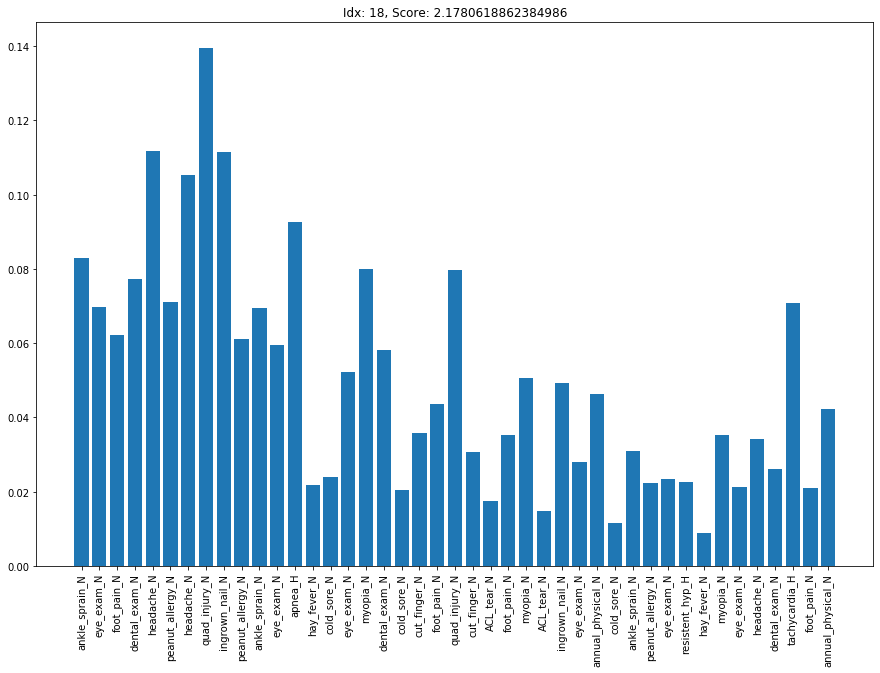

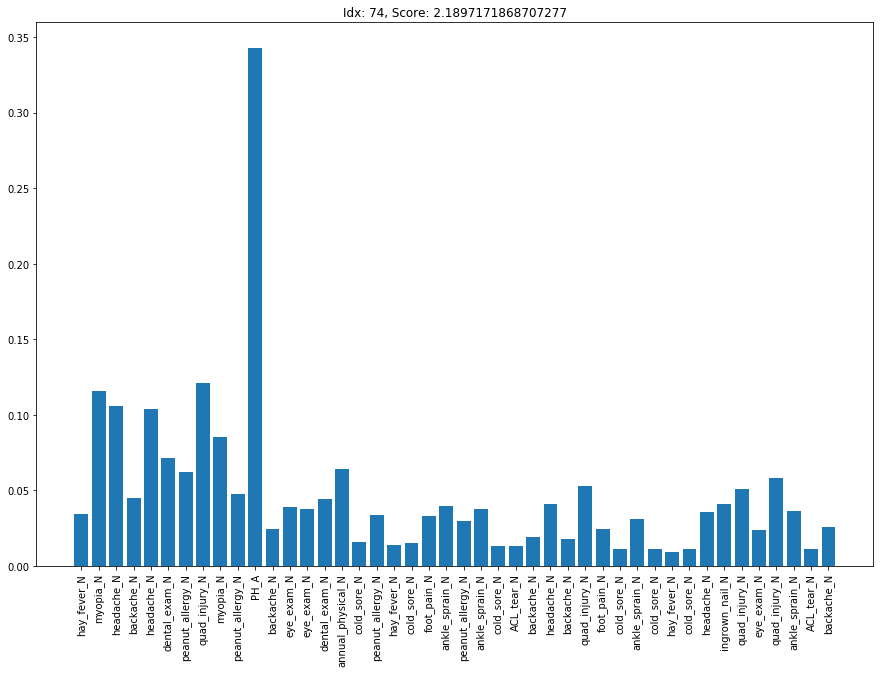

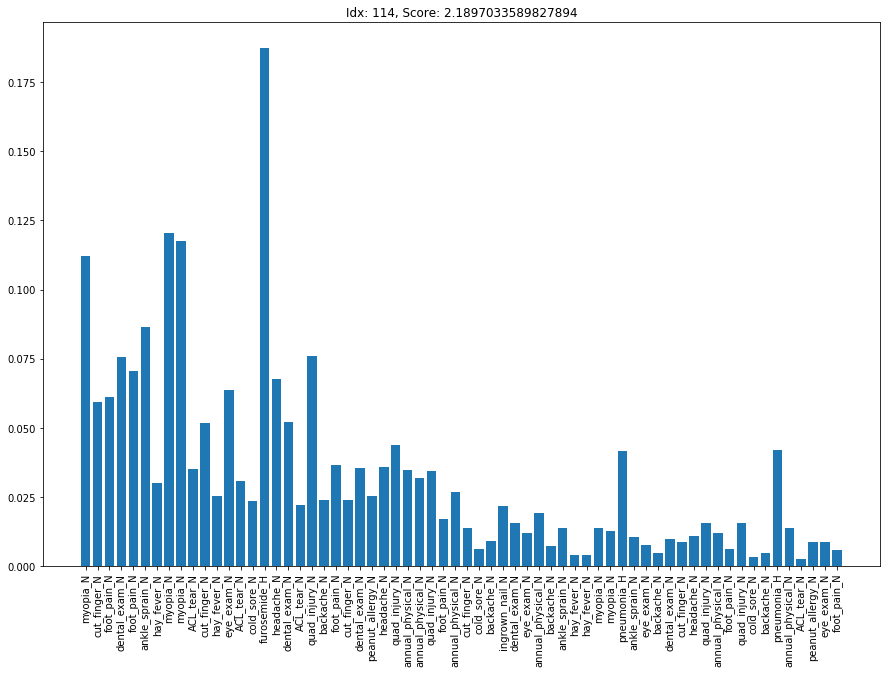

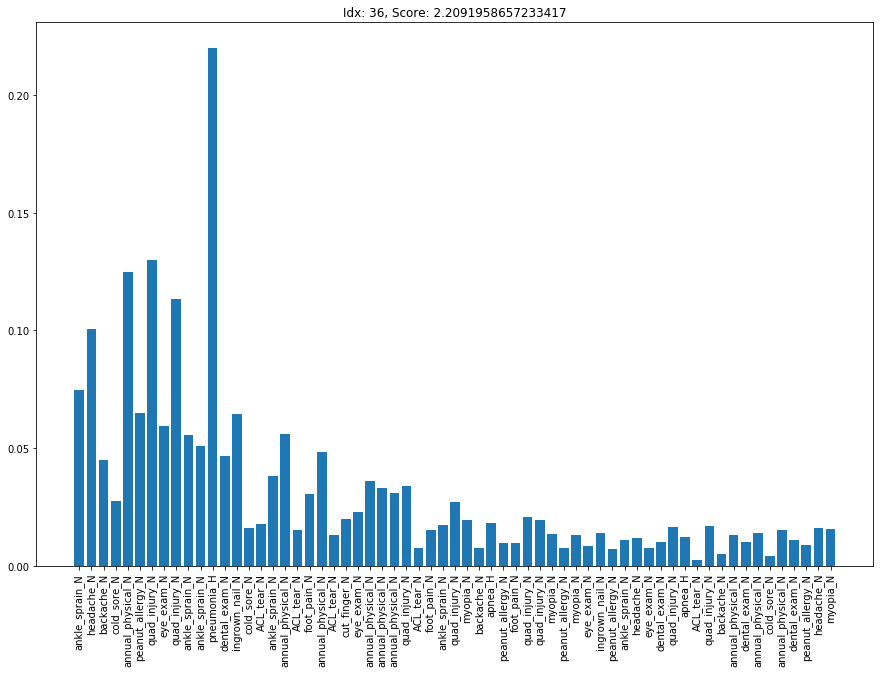

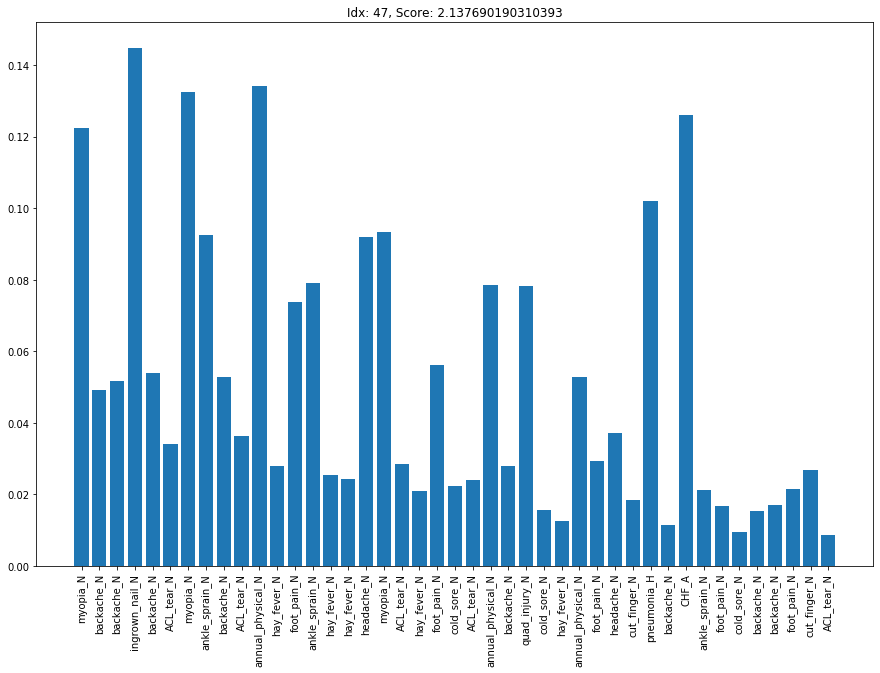

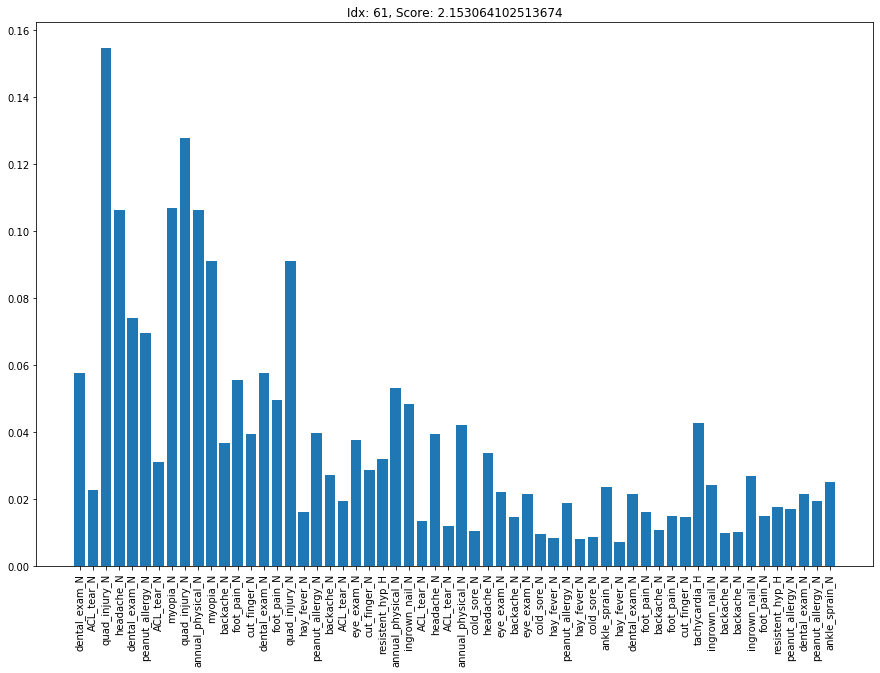

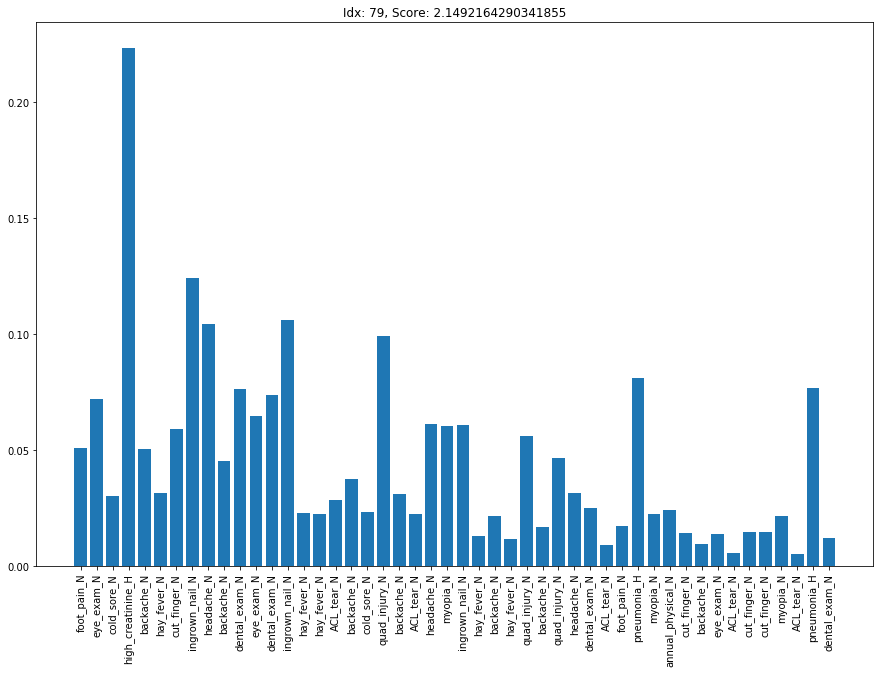

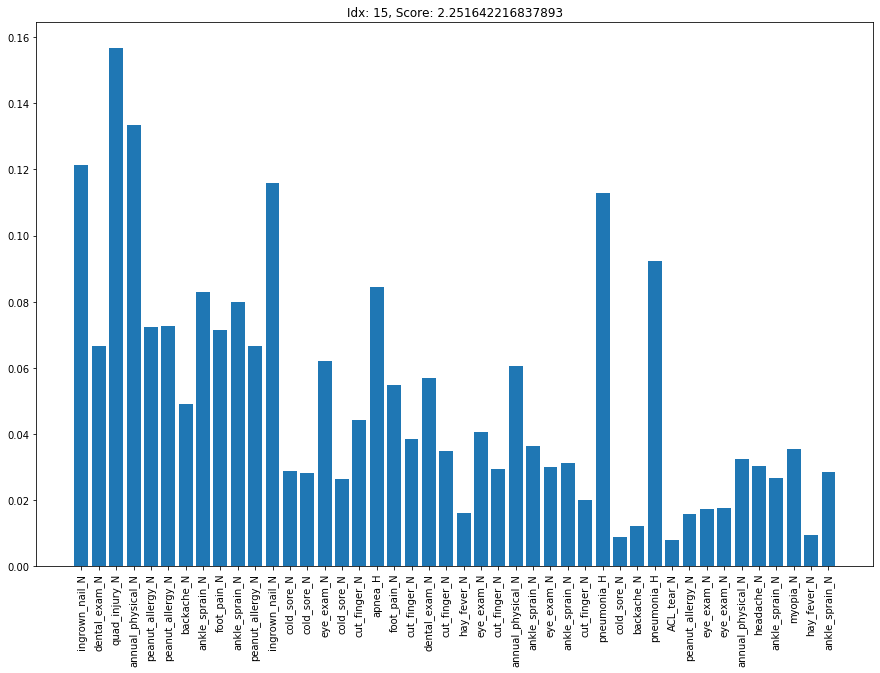

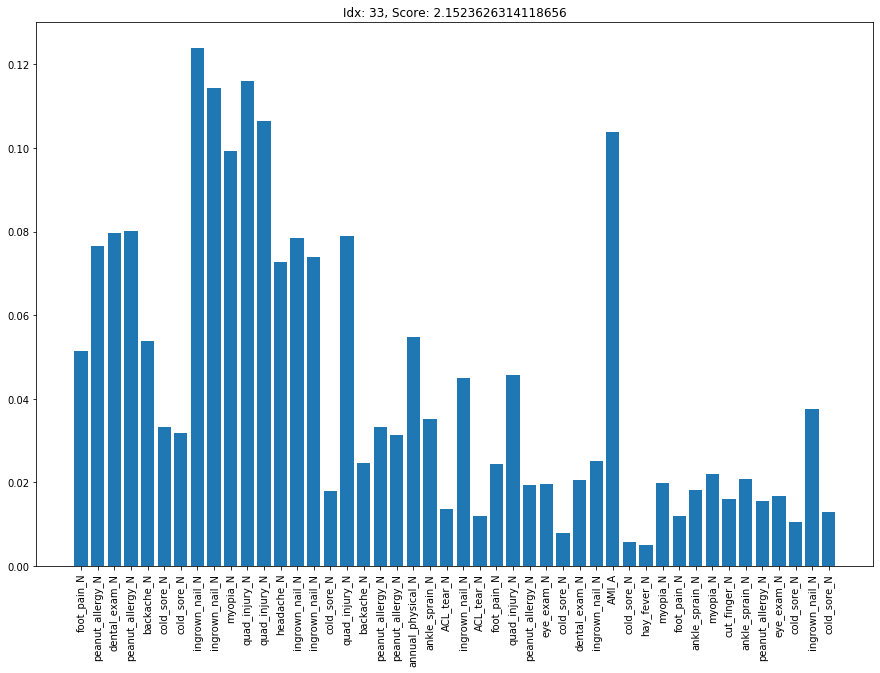

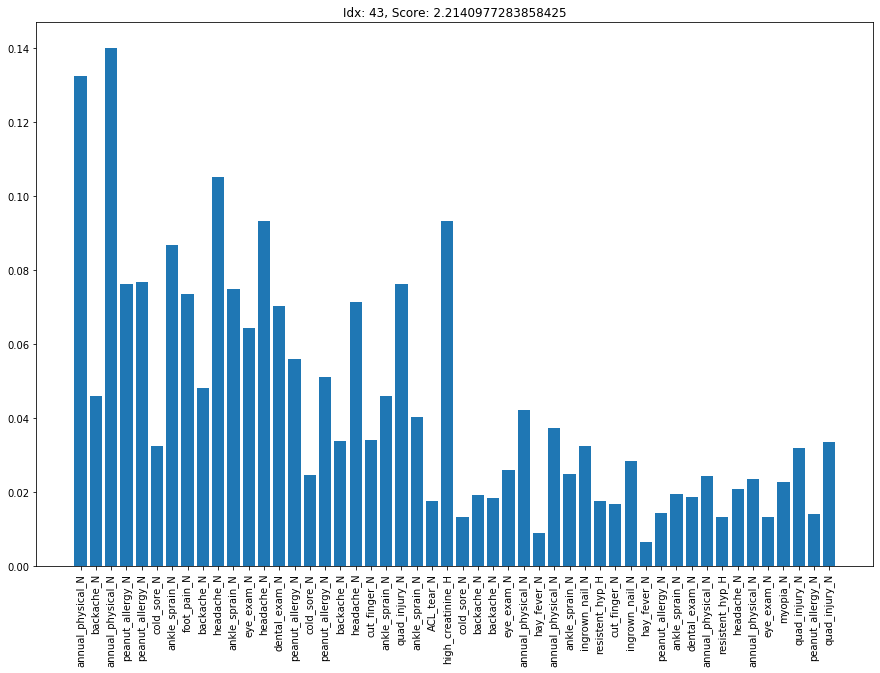

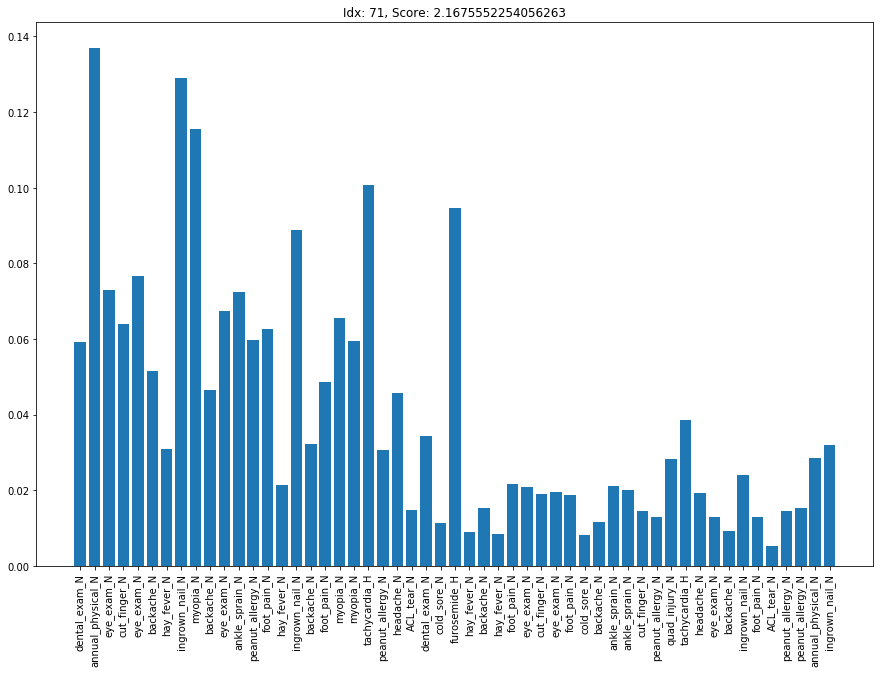

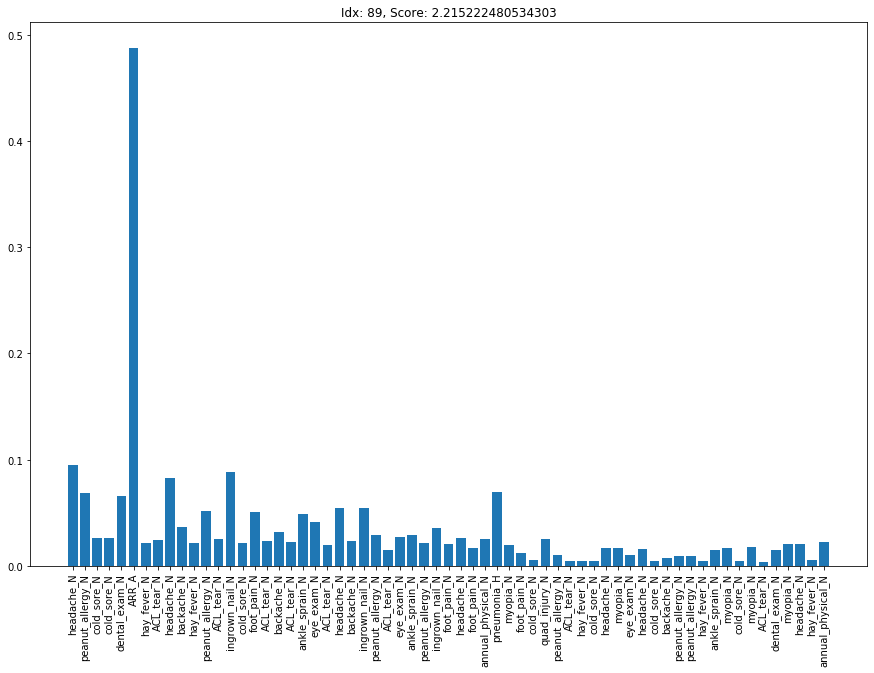

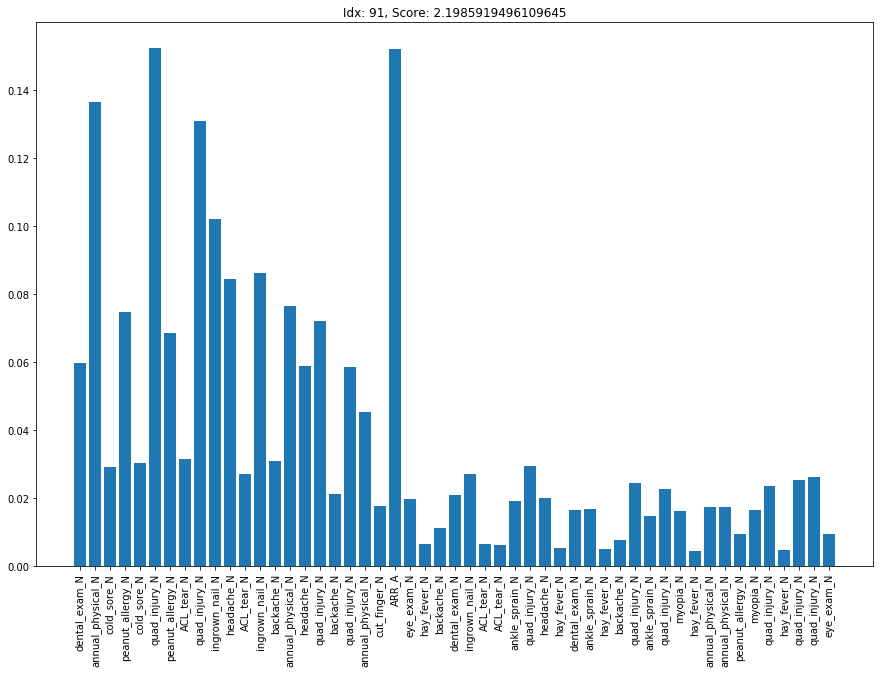

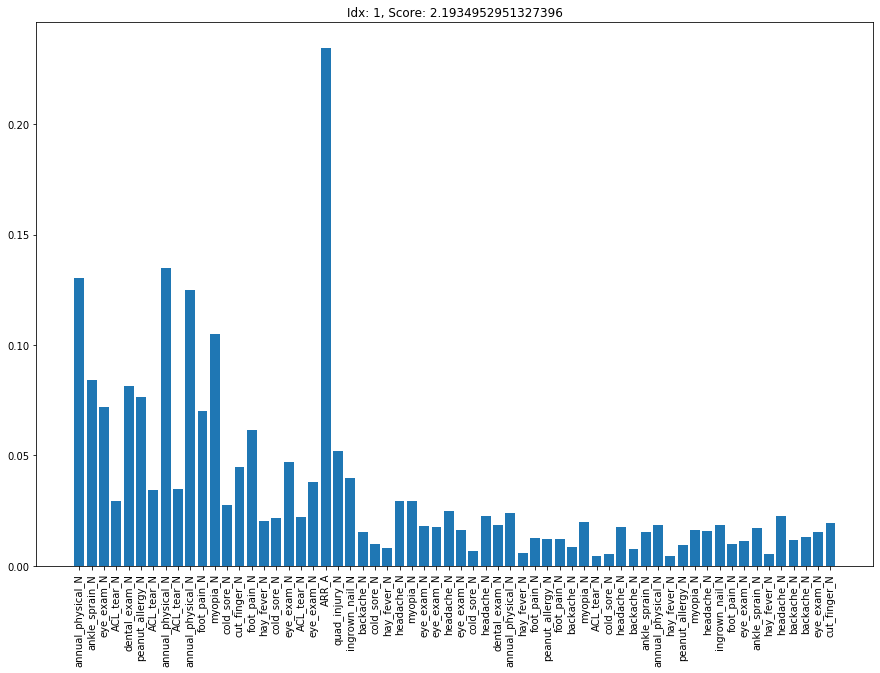

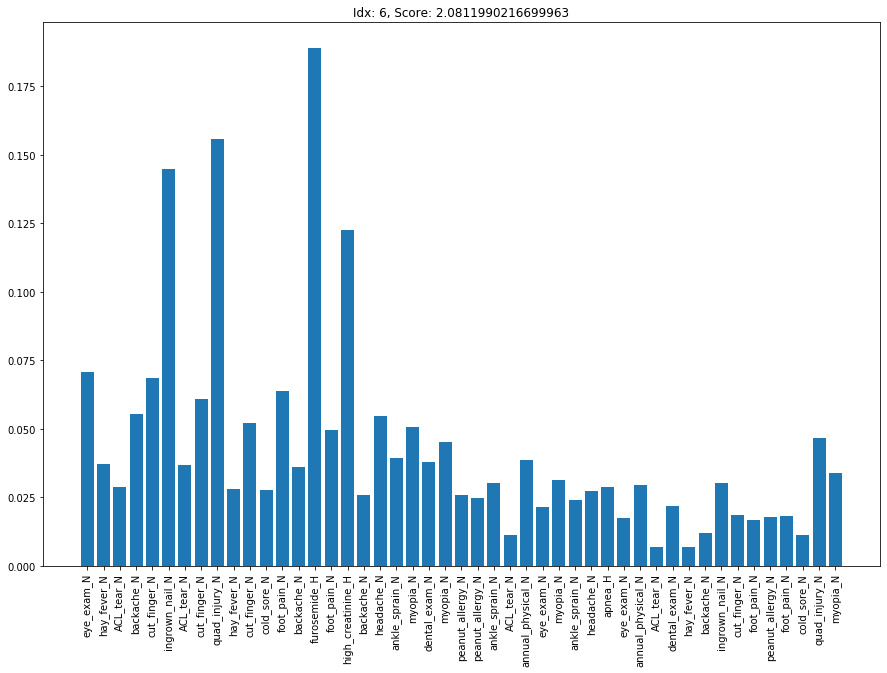

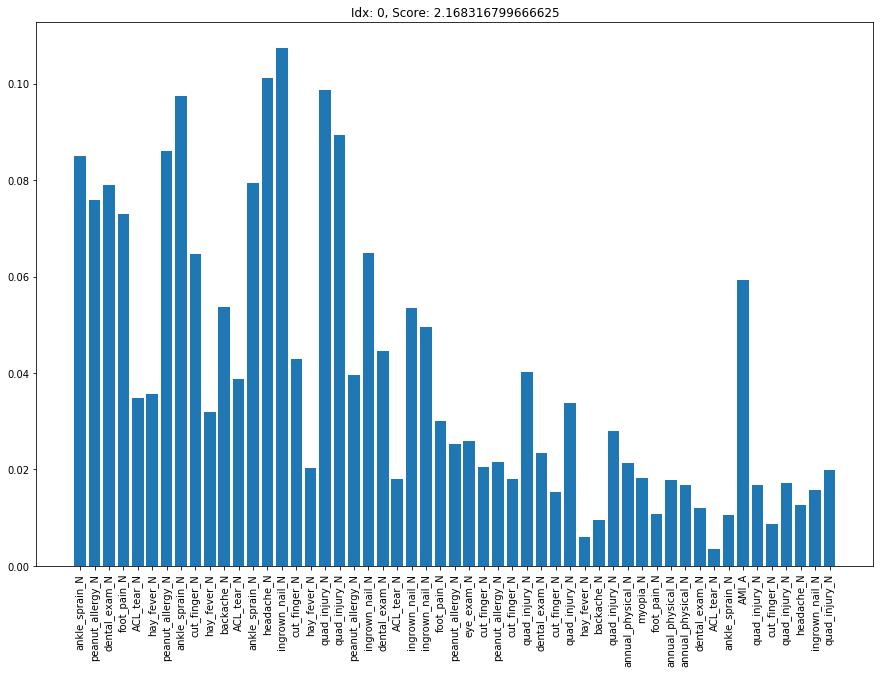

In [27]:
(ids, labels, idxed_text) = next(iter(test_dataloader))
#sel_idxes = [x for x in range(60)]
errors = []
passed = []

counter = 0
for (ids, labels, idxed_text) in (test_dataloader):
    sel_idxes = [x for x in range(len(labels))]
    
    for sel_idx in sel_idxes:
        one_text = [int(token.numpy()) for token in idxed_text[sel_idx]]
        one_text = [x for x in one_text if x != 0]
        
        #one_text_tensor = torch.Tensor(one_text)
        #one_text_tensor = one_text_tensor.type(torch.long)
        #one_text_tensor = one_text_tensor.unsqueeze(0).cuda()
        
        lrp_model.set_input(one_text)
        
        if len(lrp_model.w) < 65 and len(lrp_model.w) > 40:
            lrp_model.forward_lrp()

            Rx, Rx_rev, R_rest  = lrp_model.lrp(one_text, 0, eps=1e-6, bias_factor=1)
            Rtot = Rx.sum() + Rx_rev.sum() + R_rest.sum()  


            #print(f"\nResults for {sel_idx}")

            above_layers_R = 0
            for layer in reversed(range(lrp_model.nlayers)):

                Rtot =  lrp_model.Rx[layer].sum() + lrp_model.Rx_rev[layer][::-1,:].sum() + \
                        (lrp_model.Rh_Left[layer][-1].sum()+lrp_model.Rc_Left[layer ][-1].sum()+ \
                        lrp_model.Rh_Right[layer][-1].sum()+lrp_model.Rc_Right[layer][-1].sum()).sum()


                if layer != (lrp_model.nlayers -1):     
                    above_layers_R += (lrp_model.Rh_Left[layer+1][-1].sum()+lrp_model.Rc_Left[layer+1 ][-1].sum()+ \
                        lrp_model.Rh_Right[layer+1][-1].sum()+lrp_model.Rc_Right[layer+1][-1].sum()).sum()

            errors.append(np.round(Rtot - lrp_model.s[0] + above_layers_R, 10))
            passed.append(np.allclose(Rtot  + above_layers_R, lrp_model.s[0]))

            
            #if labels[sel_idx] == 1 and lrp_model.s[0] > 0:
            #print(lrp_model.s[0], labels[sel_idx][0])
            if errors[-1] < 0.1 and lrp_model.s[0] > 0:
                Rx, Rx_rev, R_rest  = lrp_model.lrp(one_text, 0, eps=1e-6, bias_factor=0)
                R_words             = np.sum(Rx + Rx_rev, axis=1) 
                df = pd.DataFrame()
                df['R'] = R_words
                df['idx'] = one_text
                df['seq_idx'] = [x for x in range(len(one_text))]
                df['token'] = [lstm_model.vocab.itos(x) for x in one_text]
            
                plt.figure(figsize=(15, 10))
                plt.bar(df.seq_idx, df.R, tick_label=df.token)
                plt.xticks(rotation=90)
                plt.title(f"Idx: {sel_idx}, Score: {lrp_model.s[0]}")
                counter += 1
        if counter >= 15: 
                break
print('\nSummary ====')
print("Error values for sanity check")
print(errors)
print(f"Mean error:{np.mean(errors)}")

print(f'\n Passed checks')
print(["Yes" if x else "Failed" for x in passed])
print(f"Mean passing:{np.mean(passed)}")
print(f"Terrible errors: {np.mean(np.array(errors) > 0.1)}")
#print(f"\nRelevance: {Rtot}")
#print(f"Score: {lrp_model.s[0]}")
#print(f"Delta= {Rtot - lrp_model.s[0]}\n")


In [28]:
lrp_model.get_attn_lrp()

array([-0.06356443, -0.06498076, -0.0800422 , -0.04450159, -0.11230744,
       -0.03126836,  0.00660234, -0.03399357, -0.0448328 , -0.01432825,
       -0.00217355,  0.00510358, -0.00332031, -0.00322419,  0.00242705,
       -0.07758837])

In [29]:
lrp_model.get_attn_values()

array([0.01527956, 0.01581896, 0.01641921, 0.01696307, 0.01728946,
       0.01765423, 0.0201999 , 0.01777967, 0.0173344 , 0.01715721,
       0.01679386, 0.01659777, 0.01629973, 0.01636305, 0.01672662,
       0.01665694, 0.01669471, 0.01639881, 0.01632402, 0.01611128,
       0.0161697 , 0.01617662, 0.01621218, 0.01629127, 0.0164893 ,
       0.01622739, 0.01577109, 0.01569005, 0.01578257, 0.01613101,
       0.01615024, 0.01603673, 0.01606502, 0.01625889, 0.015957  ,
       0.01589135, 0.01595122, 0.0162041 , 0.01611734, 0.01634631,
       0.01623895, 0.01613991, 0.01599236, 0.01604935, 0.01613388,
       0.01639594, 0.01621245, 0.02761579, 0.02966616, 0.03140345,
       0.03268078, 0.03389729, 0.03490283, 0.03788903])

In [30]:
one_text_tensor = torch.Tensor(one_text)
one_text_tensor = one_text_tensor.type(torch.long)
one_text_tensor = one_text_tensor.unsqueeze(0).cuda()

In [41]:
lstm_model_cuda = lstm_model.cuda()
pred, attn_weights, _a, _c, _d, _e = lstm_model_cuda(one_text_tensor.cuda(), True)

In [58]:
idxed_text[0]

tensor([23, 11, 13,  6, 16,  9, 23, 13, 11, 11, 13,  8, 12, 13,  7,  2,  3,  3,
         2,  2, 10, 10,  2, 13, 10,  3, 21,  7,  8, 11, 11, 11,  3,  9, 13, 14,
        16, 11,  4,  4,  7, 16,  3,  9, 10,  9, 10,  2,  7,  9, 15,  3,  6,  8,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0, 

In [59]:
Rx, Rx_rev, R_rest  = lrp_model.lrp(one_text, 0, eps=1e-6, bias_factor=0)

In [73]:
R_words             = np.sum(Rx + Rx_rev, axis=1) 
df = pd.DataFrame()
df['R'] = R_words
df['idx'] = one_text
df['seq_idx'] = [x for x in range(len(one_text))]
df['token'] = [lstm_model.vocab.itos(x) for x in one_text]
df['attn_weights'] = lrp_model.get_attn_values()

df.index = df.token

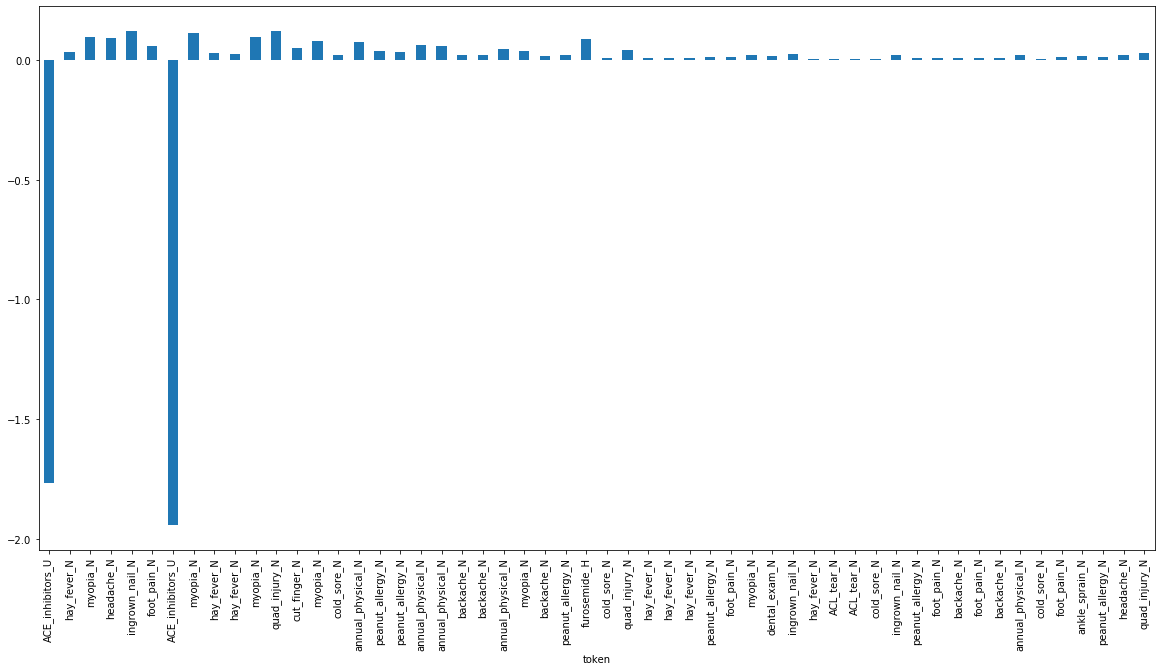

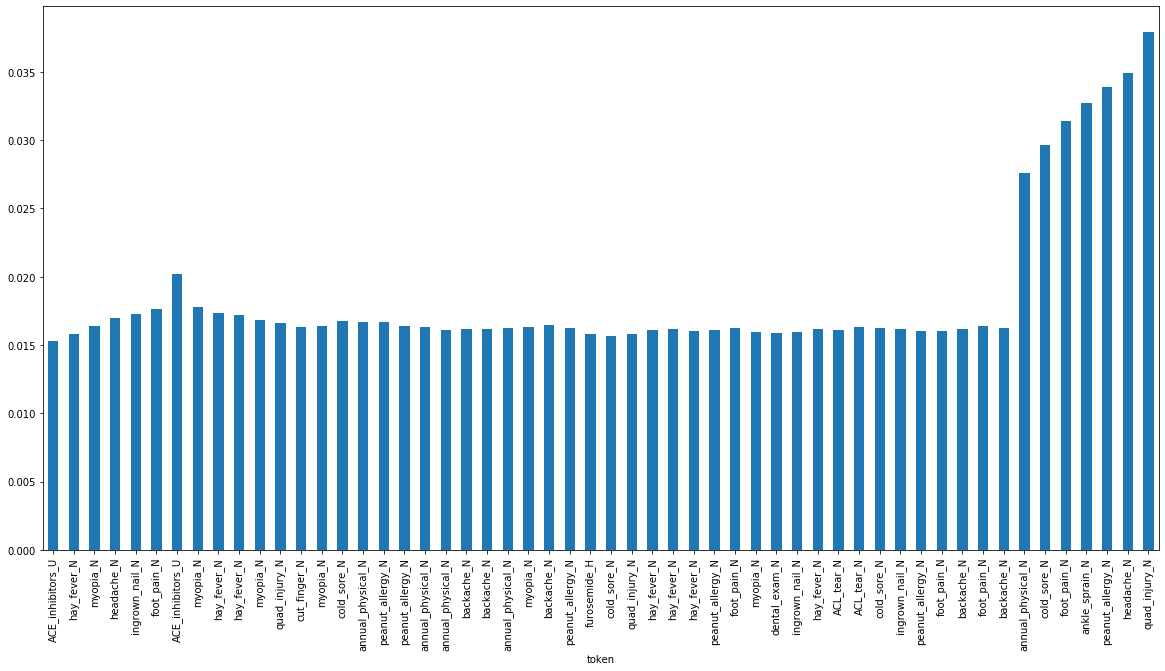

In [79]:
plt.figure()
df['R'].plot(kind='bar', figsize=(20, 10))
plt.figure()
df['attn_weights'].plot(kind='bar', figsize=(20, 10))



In [44]:
one_text_tensor

tensor([[23, 11, 13,  6, 16,  9, 23, 13, 11, 11, 13,  8, 12, 13,  7,  2,  3,  3,
          2,  2, 10, 10,  2, 13, 10,  3, 21,  7,  8, 11, 11, 11,  3,  9, 13, 14,
         16, 11,  4,  4,  7, 16,  3,  9, 10,  9, 10,  2,  7,  9, 15,  3,  6,  8]],
       device='cuda:0')

In [40]:
len(one_text)

54

In [179]:
np.mean(lrp_model.Rctxt_Left + lrp_model.Rctxt_Right[::-1], axis=-1)

-0.04066833121455113

In [23]:
np.set_printoptions(suppress=True)

In [24]:
lrp_model.Rctxt_Left

array([-0.13404043, -0.12012673, -0.1625131 , -0.08584826, -0.22488346,
       -0.07319228, -0.02847225, -0.05098715, -0.13145546, -0.03433558,
       -0.00804915, -0.01120789, -0.0039807 , -0.00258902,  0.03071481,
       -0.13355131])

In [25]:
lrp_model.Rctxt_Right[::-1]

array([ 0.00691156, -0.00983479,  0.00242871, -0.00315491,  0.00026858,
        0.01065557,  0.04167692, -0.01699999,  0.04178985,  0.00567908,
        0.00370205,  0.02141505, -0.00265992, -0.00385937, -0.02586071,
       -0.02162544])

In [26]:
0.5 * (lrp_model.Rctxt_Left + lrp_model.Rctxt_Right[::-1])

array([-0.06356443, -0.06498076, -0.0800422 , -0.04450159, -0.11230744,
       -0.03126836,  0.00660234, -0.03399357, -0.0448328 , -0.01432825,
       -0.00217355,  0.00510358, -0.00332031, -0.00322419,  0.00242705,
       -0.07758837])